<a href="https://colab.research.google.com/github/thomasdevasia/deep-image-prior/blob/master/denoise_sar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [9]:
# fname = 'data/denoising/F16_GT.png'
fname = 'data/denoising/SAR.png'

# Load and prepare Image

In [10]:
# if fname == 'data/denoising/snail.jpg':
#     img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
#     img_noisy_np = pil_to_np(img_noisy_pil)
    
#     # As we don't have ground truth
#     img_pil = img_noisy_pil
#     img_np = img_noisy_np
    
#     if PLOT:
#         plot_image_grid([img_np], 4, 5);
        
# elif fname == 'data/denoising/F16_GT.png':
#     # Add synthetic noise
#     img_pil = crop_image(get_image(fname, imsize)[0], d=32)
#     img_np = pil_to_np(img_pil)
    
#     img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
#     if PLOT:
#         plot_image_grid([img_np, img_noisy_np], 4, 6);
# else:
#     assert False

In [14]:
# img_pil = get_image(fname, imsize)[0]
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
# converting to numpy
img_np = pil_to_np(img_pil)

In [15]:
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

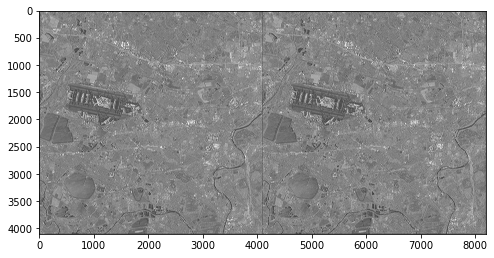

In [16]:
plot_image_grid([img_np, img_noisy_np], 4, 6);

# Define model

In [76]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

In [77]:
num_iter = 3000
input_depth = 32 
figsize = 4 

In [78]:
# returns a model
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

In [79]:
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

In [80]:
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

Number of params: 2217831


In [81]:
# Loss
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

# run model

In [82]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0

In [83]:
# Loss funftion printing image
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

In [84]:
p = get_params(OPT_OVER, net, net_input)

In [85]:
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


RuntimeError: ignored

In [17]:
out_np = torch_to_np(net(net_input))

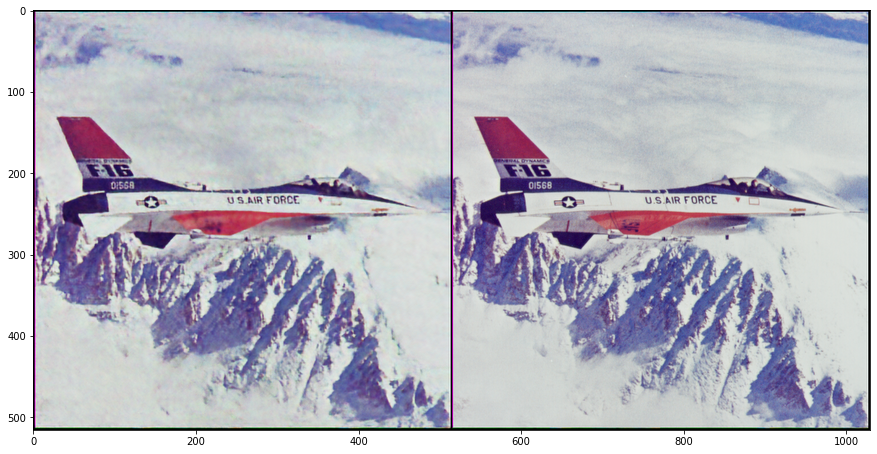

In [20]:
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);